Plotting functions to plot histograms with scale variations

In [4]:
# import required module
import numpy as np
import os
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
plt.style.use(hep.style.CMS)

def read_file(f):
    df = pd.read_csv(f, sep="\t")
    return df

def get_combined_data(directory):
    dfs = [read_file(os.path.join(directory, f)) for f in os.listdir(directory)]
    SumWeight = np.sum([df.sumWeight[0] for df in dfs])
    DF = pd.concat(dfs, ignore_index=True)
    DF['SumWeight']= SumWeight
    return DF
    
def get_hist(DF, nbins, var, scale, sum):
    if sum == 'N':
        DF['w'] = DF.genWeights * (DF.N_exp / DF.SumWeight )
        DF['w2'] = np.square(DF.w)
    elif sum == 'SR':
        DF['w'] = DF.genWeights * DF[scale] * (DF.N_exp / DF.SumWeight )
        DF['w2'] = np.square(DF.w)
    else:
        DF['w'] = DF.genWeights * DF[scale] * (DF.N_exp / (DF.SumWeight * DF[sum]))
        DF['w2'] = np.square(DF.w)
    clipped = np.clip(DF[var], nbins[0], nbins[-1])
    hist, _ = np.histogram(clipped, bins=nbins, weights=DF.w)
    w2, _ = np.histogram(clipped, bins=nbins, weights=DF.w2)
    w = np.sqrt(w2)
    return hist, w

def combine_bins(data):
    return [sum(x) for x in zip(*data)]

def combine_w2s(w2s):
    return [np.sqrt(sum(np.square(x))) for x in zip(*w2s)]

def get_Signal_BG(background, signal):
    BG = np.sum(background, axis=0)
    BG2 = np.sqrt(BG)
    S_BG2 = signal/BG2
    return S_BG2

def make_layout(var, ratios):
    xlabels = {"eta" : "$\eta$", "pt": "$p_T$ (GeV)", "mass": "mass (GeV)", 'M_sd': r'$M_{SD}$', 'AK8pt': r'$p_{T, AK8}$ (GeV)',
                "phy": "$\phi$", "CA": r"$\Delta^{t}_{\eta}$", "dR": r"$\Delta{r}$", "t32": r"$\tau_{32}$", 'n': 'N', 'Ht': r'H$_T$'}
    if (ratios!='None'):
        fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, 
                                    gridspec_kw={'height_ratios': [2, 1]})
        ax0.yaxis.set_label_coords(-0.1, -6)
        ax0.set_ylabel(r'N$_{events}$', fontsize=20)
        ax1.set_xlabel(xlabels[var], fontsize=20)
        ax1.set_ylim(0.85, 1.15)
        ax1.set_ylabel(ratios, fontsize=20)
        ax1.xaxis.set_label_coords(1, -0.25)
        ax1.yaxis.set_label_coords(-0.1, 0.6)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0)
        return ax0, ax1
        
    else:
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.set_ylabel(r'N$_{events}$', fontsize=20)
        ax.set_xlabel(xlabels[var], fontsize=20)
        return ax

def gen_colors(labels):
    c = {'ttZ': "#3f90da", 'ttW': "#bd1f01" , 'DYJets': "#ffa90e", 'ttH': "#94a4a2", 'tt': "#832db6", 'ZZ': "#a96b59",
         'WZ': "#b9ac70", 'other':  "#e76300", 'ZZ2': "#717581", 'WZ2': "#92dadd", 'ttG': 'g', 'tWZ': 'b'}
    return [c[lab] for lab in labels]

def plot(title, data, w2s, bins, var, labels, ratio):
    width = (bins[0] + bins[1]) / 2
    midpoints = (bins[:-1] + bins[1:]) / 2
    edges = midpoints - width
    #edges = bins[:-1]
    if ratio=='None':
        ax = make_layout(var, 'None')
        #ax.set_title(title, size=16, y=1.2)
        hep.cms.label(ax=ax, fontsize=16, llabel='Simulation Internal', rlabel=r'138 fb$^{-1}$ (13 TeV)')
        hep.histplot(data, bins, histtype='fill', color=gen_colors(labels), stack=True, ax=ax, label=labels, binwnorm=None, ec='black')
        opts = {'step': 'post', 'label': 'Stat. unc.', 'hatch': '///',
                        'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0}
        #ax.fill_between(x=edges, y1=data-np.sqrt(w2s), y2=data+np.sqrt(w2s), **opts)
        ax.fill_between(x=edges, y1=np.sum(data, axis=0)-np.sqrt(w2s), y2=np.sum(data, axis=0)+np.sqrt(w2s), **opts)
        ax.legend(fontsize=16)
    if ratio =='SBG':
        ax, ax2 = make_layout(var, r'S/$\sqrt{BG}$')
        ax.set_title(title, size=16, y=1.2)
        hep.cms.label(ax=ax, fontsize=16, llabel='Simulation Internal', rlabel=r'138 fb$^{-1}$ (13 TeV)')
        hep.histplot(data, bins, histtype='fill', stack=True, ax=ax, label=labels, binwnorm=None)
        opts = {'step': 'post', 'label': 'Stat. unc.', 'hatch': '///',
                        'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0}
        ax.fill_between(x=edges, y1=np.sum(data, axis=0)-np.sqrt(w2s), y2=np.sum(data, axis=0)+np.sqrt(w2s), **opts)
        ax.legend(fontsize=12)
        SBG = get_Signal_BG(data[::-1], data[-1])
        ax2.scatter(midpoints, SBG, color='black', marker='+', label='mean = {:0.2f}'.format(np.mean(SBG)))
        ax2.legend(fontsize=16, loc='upper left')
    return ax

In [2]:
DFS = get_combined_data('final_results/scaled_hists/output_TTZ3l/')
bins = np.linspace(0, 1000, 10)
var = 'AK8_pt'

nom_bins, _ = get_hist(DFS, bins, var, 'nom', 'N')
dd_bins, _ = get_hist(DFS, bins, var, 'LHE_dd', 'LHES_dd')
dm_bins, _ = get_hist(DFS, bins, var, 'LHE_dm', 'LHES_dm')
md_bins, _ = get_hist(DFS, bins, var, 'LHE_md', 'LHES_md')
mu_bins, _ = get_hist(DFS, bins, var, 'LHE_um', 'LHES_um')
um_bins, _ = get_hist(DFS, bins, var, 'LHE_mu', 'LHES_mu')
uu_bins, _ = get_hist(DFS, bins, var, 'LHE_uu', 'LHES_uu')
isr_u, _ = get_hist(DFS, bins, var, 'ISR_u', 'SR')
isr_d, _ = get_hist(DFS, bins, var, 'ISR_d', 'SR')
fsr_u, _ = get_hist(DFS, bins, var, 'FSR_u', 'SR')
fsr_d, _ = get_hist(DFS, bins, var, 'FSR_d', 'SR')

scales = [dd_bins, dm_bins, md_bins, mu_bins, um_bins, uu_bins, isr_u, isr_d, fsr_u, fsr_d]


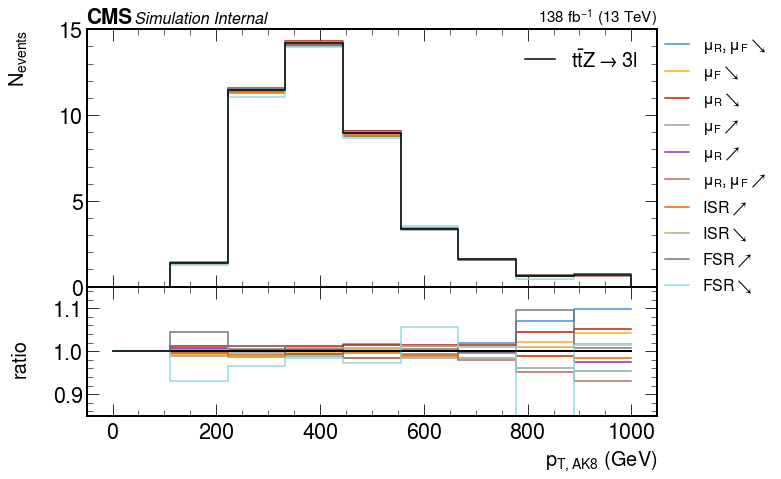

In [5]:

labels = ["$\mu_R, \mu_F \searrow$", "$\mu_F \searrow$",  "$\mu_R \searrow$",
                        "$\mu_F \\nearrow$", "$\mu_R \\nearrow$", "$\mu_R, \mu_F \\nearrow$",
                        "$ISR \\nearrow$", "$ISR \\searrow$", "$FSR \\nearrow$", "$FSR \\searrow$"]
colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"] 
            
ax, ax1 = make_layout('AK8pt', 'ratio')  
midpoints = (bins[:-1] + bins[1:]) / 2  
hep.histplot(scales, bins, ax=ax, binwnorm=None, color=colors)
hep.histplot(nom_bins, bins, ax=ax, binwnorm=None, label=r'$t\bar{t}Z \rightarrow 3l$', color='black')
hep.cms.label(ax=ax, fontsize=16, llabel='Simulation Internal', rlabel=r'138 fb$^{-1}$ (13 TeV)')
ax.legend(fontsize=20)

for i, scale in enumerate(scales):
    with np.errstate(divide='ignore', invalid='ignore'):
                ratio = scale /nom_bins
                ratio[0] = 1
                n = nom_bins /nom_bins
                n[0] = 1
                ratio = np.where(np.isnan(ratio), 0, ratio)
                ratio = np.where(np.isnan(ratio), 0, ratio)
    hep.histplot(ratio, bins, color=colors[i], label=labels[i], edges=False)
    hep.histplot(n, bins, color='black', edges=False)
ax1.legend(bbox_to_anchor=(1, 3), loc=2, borderaxespad=0., fontsize=16)
